In [3]:
import numpy as np
import pystan
from data_pertub import *
from mcmc_plot import *
from PPCA_pystan import *
import warnings
from PPCA_pystan import *
warnings.filterwarnings("ignore")

## 1. Generate Data

In [4]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
data_config = dict(config['data_config'])


In [5]:
n_sample = int(data_config['n_sample'])
alpha = float(data_config['alpha'])


d = int(data_config['d'])
q_star = int(data_config['q_star'])
a_vj = float(data_config['a_vj']) * np.ones(q_star)
epsilon = float(data_config['epsilon'])
beta_vj = epsilon * (a_vj - 1)
beta_sigma2 = float(data_config['beta_sigma2'])
a_sigma2 = float(data_config['a_sigma2'])

prior_param_true = dict({'beta_sigma2': beta_sigma2,
                    'a_sigma2': a_sigma2,
                    'a_vj': a_vj,
                    'beta_vj': beta_vj
                    })

y_true, W_star, Z_star, sigma2_star, v_star_list = forward_sample(d, q_star, n_sample, prior_param_true, verbose = True)
y_perturbation = sample_perturbation2(y_true, n_sample, alpha)

true sigma2_star is 0.654792183538593
true v_j list is [0.43578041 0.28549013 0.30806428 0.42351925]


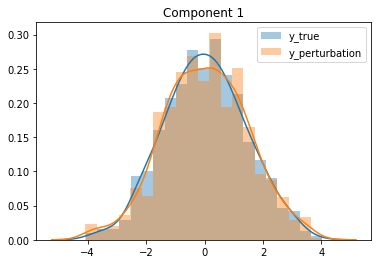

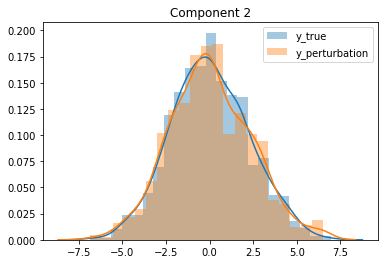

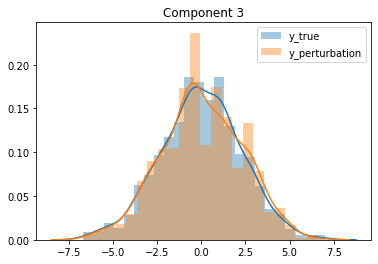

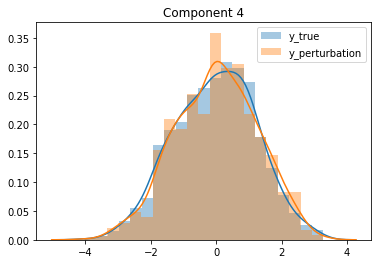

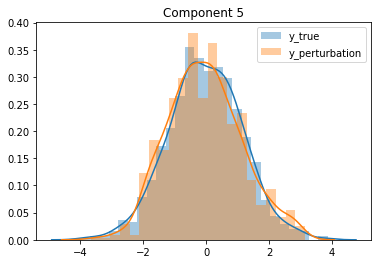

In [6]:
for j in range(d):    
    sns.distplot(y_true[j,:], label='y_true')
    sns.distplot(y_perturbation[j,:], label='y_perturbation')
    plt.legend()
    plt.title('Component '+ str(j+1))
    plt.show()
    
X = y_true

## 2. MCMC Prior and Starting Point


In [7]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
mcmc_setup = dict(config['mcmc_setup'])

In [8]:
# inference parameter
d = int(data_config['d'])
q = int(mcmc_setup['q'])
xi = float(mcmc_setup['xi'])


# prior parameter
beta_sigma2 = float(mcmc_setup['beta_sigma2'])
a_sigma2 = float(mcmc_setup['a_sigma2'])
a_vj = float(mcmc_setup['a_vj']) * np.ones(q)
epsilon = float(mcmc_setup['epsilon'])
beta_vj = epsilon * (a_vj - 1)


# sampling parameter
prior_param_mcmc = dict({'beta_sigma2': beta_sigma2,
                    'a_sigma2': a_sigma2,
                    'a_vj': a_vj,
                    'beta_vj': beta_vj
                    })


In [9]:
n_chains = int(mcmc_setup['n_chains'])
iterations = int(mcmc_setup['iterations'])

In [13]:

ppca_code = """
data { 
 int D; //number of dimensions
 int N; //number of data
 int Q; //number of principle components
 vector[D] x[N]; //data
 real a_vj; // w_j prior 
 real epsilon;// w_j mean
 real xi; // power parameter
 real a_sigma2; // sigma2 prior 
 real beta_sigma2;// sigma2 mean
 }

parameters {
 ordered[Q] v; // v_j
 real<lower=0> sigma2; //data sigma2
 matrix[Q,D] W; //projection matrix
}
model {

matrix[D,D] C; //covaraince matrix
matrix[D,D] L_C; //covaraince matrix


for(j in 1:Q){
    v[j] ~ inv_gamma(a_vj, epsilon * (a_vj -1));
    W[j] ~ multi_normal(rep_vector(0,D), v[j] * diag_matrix(rep_vector(1, D)));
    }

sigma2 ~ inv_gamma(a_sigma2, beta_sigma2);
C = crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D));
L_C = cholesky_decompose(C);

for(n in 1:N){
C = crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D));

target += xi * multi_normal_lpdf(x[n]|rep_vector(0,D), C);
}
for (j in 1:Q){
target += multi_normal_lpdf(W[j]|rep_vector(0,D), v[j] * diag_matrix(rep_vector(1, D)));
target += inv_gamma_lpdf(v[j] | a_vj, epsilon * (a_vj -1));
}

target += inv_gamma_lpdf(sigma2 | a_sigma2, beta_sigma2);
}

generated quantities {
vector[D] y_hat[N]; //predictive
matrix[D,D] C; //covaraince matrix

C = crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D));
    for (n in 1:N) {
        y_hat[n] = multi_normal_rng(rep_vector(0,D), C);
    }
}

"""

In [14]:
sm = pystan.StanModel(model_code = ppca_code) # code compile

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_db531a219b8e3320e502e1f6e615341c NOW.


In [15]:
init_list=[]
for i_ in range(n_chains):
    temp_dict={
        'v': 1/np.random.gamma(a_vj, 1/ beta_vj),
        'sigma2': 1/np.random.gamma(a_sigma2, 1/beta_sigma2),
        "w0": np.random.normal(0, 1, [q, d])
    }
    init_list.append(temp_dict)

In [21]:
init_list=[]
for i_ in range(n_chains):
    temp_dict={
#        'v': np.repeat(v_star_list, q).ravel(),
        'v': sorted(v_star_list),
        'sigma2': sigma2_star,
        "w0": W_star.T
    }
    init_list.append(temp_dict)

## 3. MCMC Standard

In [17]:
print(sm.model_code)


data { 
 int D; //number of dimensions
 int N; //number of data
 int Q; //number of principle components
 vector[D] x[N]; //data
 real a_vj; // w_j prior 
 real epsilon;// w_j mean
 real xi; // power parameter
 real a_sigma2; // sigma2 prior 
 real beta_sigma2;// sigma2 mean
 }

parameters {
 ordered[Q] v; // v_j
 real<lower=0> sigma2; //data sigma2
 matrix[Q,D] W; //projection matrix
}
model {

matrix[D,D] C; //covaraince matrix
matrix[D,D] L_C; //covaraince matrix


for(j in 1:Q){
    v[j] ~ inv_gamma(a_vj, epsilon * (a_vj -1));
    W[j] ~ multi_normal(rep_vector(0,D), v[j] * diag_matrix(rep_vector(1, D)));
    }

sigma2 ~ inv_gamma(a_sigma2, beta_sigma2);
C = crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D));
L_C = cholesky_decompose(C);

for(n in 1:N){
C = crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D));

target += xi * multi_normal_lpdf(x[n]|rep_vector(0,D), C);
}
for (j in 1:Q){
target += multi_normal_lpdf(W[j]|rep_vector(0,D), v[j] * diag_matrix(rep_vector(1, D)));
targ

In [18]:
ppca_dat_standard = {'D': d,
            'N': n_sample,
            'Q': q,
            'x': X.reshape([n_sample, d]),
            'xi': 1,
            'a_vj': a_vj[0],
            'epsilon': epsilon,
            'a_sigma2': a_sigma2,
            'beta_sigma2': beta_sigma2
                           }


In [ ]:
fit_standard = sm.sampling(data = ppca_dat_standard, iter = iterations, chains = n_chains, init = init_list, seed =1)

### Posterior Predictive Check

In [ ]:
y_hat = fit_standard.extract('y_hat')['y_hat'][0]

In [ ]:
for j in range(d):    
    sns.distplot(y_true[j,:], label='y_true')
    sns.distplot(y_hat[:,j], label='y_hat')
    plt.legend()
    plt.title('Component '+ str(j+1))
    plt.show()
    

In [ ]:
v_star_list

In [ ]:
sigma2_star

In [ ]:
az_v_sigma2_plot(fit_standard)

## 4. MCMC Exact

In [ ]:
ppca_dat_exact = ppca_dat_standard.copy()
ppca_dat_exact['xi']= xi

In [ ]:
fit_exact = sm.sampling(data = ppca_dat_exact, iter = iterations, chains = n_chains, init = init_list,  seed =1)

In [ ]:
v_star_list

In [ ]:
sigma2_star

In [ ]:
az_v_sigma2_plot(fit_exact)

In [ ]:
print(mcmc_setup)

In [ ]:
print(data_config)